In [266]:
import do_mpc
import numpy as np
from casadi import vertcat, cross, norm_fro, inv, MX, skew, inv_minor, DM, cos, sin, transpose

In [267]:
import casadi

In [268]:
dir(casadi)

['CASADI_INT_TYPE_STR',
 'Callback',
 'Callback_swigregister',
 'Callback_type_name',
 'CasadiMeta',
 'CasadiMeta_build_type',
 'CasadiMeta_compiler',
 'CasadiMeta_compiler_flags',
 'CasadiMeta_compiler_id',
 'CasadiMeta_feature_list',
 'CasadiMeta_git_describe',
 'CasadiMeta_git_revision',
 'CasadiMeta_install_prefix',
 'CasadiMeta_modules',
 'CasadiMeta_plugins',
 'CasadiMeta_swigregister',
 'CasadiMeta_version',
 'CodeGenerator',
 'CodeGenerator_swigregister',
 'DM',
 'DM_binary',
 'DM_deserialize',
 'DM_eye',
 'DM_from_array',
 'DM_from_csc',
 'DM_from_file',
 'DM_get_free',
 'DM_get_input',
 'DM_get_max_depth',
 'DM_inf',
 'DM_matrix_matrix',
 'DM_matrix_scalar',
 'DM_nan',
 'DM_rand',
 'DM_rng',
 'DM_scalar_matrix',
 'DM_set_max_depth',
 'DM_set_precision',
 'DM_set_scientific',
 'DM_set_width',
 'DM_swigregister',
 'DM_triplet',
 'DM_type_name',
 'DM_unary',
 'DaeBuilder',
 'DaeBuilder_swigregister',
 'Deprecate',
 'DeserializerBase',
 'DeserializerBase_swigregister',
 'FLAG',
 

In [269]:
model_type = 'continuous'
symvar_type = 'MX'
model = do_mpc. model.Model(model_type, symvar_type)

In [270]:
#variables
lin_acc = model.set_variable(var_type='_x', var_name='lin', shape=(3, 1))
M = model.set_variable(var_type='_x', var_name='M', shape=(3, 1))
ang_vel = model.set_variable(var_type='_x', var_name='ang_vel', shape=(3, 1))
ang = model.set_variable(var_type='_x', var_name='ang', shape=(3, 1))

aim = model.set_variable(var_type='_x', var_name='aim', shape=(3, 1))

rps =  model.set_variable(var_type='_u', var_name='rps', shape=(4, 1)) #Rounds per second

In [271]:
#constants
C_t = 0.112
C_f = 0.98
m = 1
g = 9.80665
kf = 8.47e-9
km = 2.13e-11
ratio = 4.17

In [272]:
# propeller's directions
x_dir = MX([-1, 1, -1, 1])
y_dir = MX([-1, -1, 1, 1])
z_dir = MX([-1, 1, 1, -1])

#Inertia and inverse inertia matrix
J = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
J_inv = np.linalg.inv(J)

#Rotate matrix (acc2aim)
# R = np.array(
#         [[0., -ang_vel[2], ang_vel[1]],
#         [ang_vel[2], 0., -ang_vel[0]],
#         [-ang_vel[1], ang_vel[0], 0.]],
#         dtype=float
# )
# R = MX(3, 3)
# R[0, 0] = 0.
# R[0, 1] = -ang_vel[2]
# R[0, 2] = ang_vel[1]
# R[1, 0] = ang_vel[2]
# R[1, 1] = 0.
# R[1, 2] = -ang_vel[0]
# R[2, 0] = -ang_vel[1]
# R[2, 1] = ang_vel[0]
# R[2, 2] = 0.

# R_inv = inv(R)

In [273]:
dir(MX)

['T',
 '__add__',
 '__arctan2__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__constpow__',
 '__copy__',
 '__copysign__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__fmax__',
 '__fmin__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mldivide__',
 '__module__',
 '__mpower__',
 '__mrdivide__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__rarctan2__',
 '__rconstpow__',
 '__rcopysign__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__req__',
 '__rfmax__',
 '__rfmin__',
 '__rge__',
 '__rgt__',
 '__rle__',
 '__rlt__',
 '__rmatmul__',
 '__rmldivide__',
 '__rmpower__',
 '__rmrdivide__',
 '__rmul__',
 '__rne__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__se

In [274]:
def R(ang_vec):
    R = MX(3, 3)
    R[0, 0] = cos(ang_vec[1])*cos(ang_vec[2])
    R[0, 1] = sin(ang_vec[0])*sin(ang_vec[1])*cos(ang_vec[2]) - cos(ang_vec[0])*sin(ang_vec[2])
    R[0, 2] = cos(ang_vec[0])*sin(ang_vec[1])*cos(ang_vec[2])+sin(ang_vec[0])*sin(ang_vec[2])

    R[1, 0] = cos(ang_vec[1])*sin(ang_vec[2])
    R[1, 1] = sin(ang_vec[0])*sin(ang_vec[1])*sin(ang_vec[2]) + cos(ang_vec[0])*cos(ang_vec[2])
    R[1, 2] = cos(ang_vec[0])*sin(ang_vec[1])*sin(ang_vec[2])-sin(ang_vec[0])*cos(ang_vec[2])

    R[2, 0] = -sin(ang_vec[1])
    R[2, 1] = sin(ang_vec[0])*cos(ang_vec[1])
    R[2, 2] = cos(ang_vec[0])*cos(ang_vec[1])
    return R
    # return [
    #     [cos(ang_vec[1])*cos(ang_vec[2]), sin(ang_vec[0])*sin(ang_vec[1])*cos(ang_vec[2]) - cos(ang_vec[0])*sin(ang_vec[2]), cos(ang_vec[0])*sin(ang_vec[1])*cos(ang_vec[2])+sin(ang_vec[0])*sin(ang_vec[2])],
    #     [cos(ang_vec[1])*sin(ang_vec[2]), sin(ang_vec[0])*sin(ang_vec[1])*sin(ang_vec[2]) + cos(ang_vec[0])*cos(ang_vec[2]), cos(ang_vec[0])*sin(ang_vec[1])*sin(ang_vec[2])-sin(ang_vec[0])*cos(ang_vec[2])],
    #     [-sin(ang_vec[1]), sin(ang_vec[0])*cos(ang_vec[1]), cos(ang_vec[0])*cos(ang_vec[1])]
    # ]

In [275]:
lin_acc_eq = vertcat(0, 0, C_f * MX.ones(1, 4) @ (rps**2) / m)

M_eq = vertcat(
    x_dir.T@(C_f * rps**2), 
    y_dir.T@(C_f * rps**2), 
    z_dir.T@(C_t * rps**2), 
)

#Euler's equation 
ang_acc_eq = vertcat(
    J_inv @ (M - cross(ang_vel, J @ ang_vel))
)

aim_eq = vertcat(
    -skew(ang_vel)@ transpose(R(ang))@ aim
)

#set equations
model.set_rhs("lin", lin_acc_eq)
model.set_rhs("M", M_eq)
model.set_rhs("ang_vel", ang_acc_eq)
model.set_rhs("ang", ang_vel)
model.set_rhs("aim", aim_eq)

model.setup()

In [276]:
mpc = do_mpc.controller.MPC(model)

In [277]:
setup_mpc = {
    'n_horizon': 20,#20,
    't_step': 0.1,
    'n_robust': 1,#1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [278]:
#set term, term, objective
# aim = MX([0, 0, 100])

# term = 1 - (lin_acc.T @ aim / norm_fro(lin_acc) / norm_fro(aim))
term = 1 - (transpose(MX([0, 0, 1])) @ aim / norm_fro(lin_acc) / norm_fro(aim))

mpc.set_objective(mterm=term, lterm=term)
mpc.set_rterm(
    rps = np.array([1e-2, 1e-2, 1e-2, 1e-2])
)

min_rps = 0
max_rps = (np.sqrt(ratio * m * g / 4 / kf) / 60).astype('int')
print(max_rps)

579


In [279]:
#set constraints
mpc.bounds['lower', '_u', 'rps'] = min_rps
mpc.bounds['upper', '_u', 'rps'] = max_rps

mpc.setup()

In [280]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=0.1)
simulator.setup()

In [281]:
x0 = np.array([
    0.1, 0.1, 0.1, # linear acc
    0., 0., 0., # Moments
    0., 0., 0., # angular velocities
    0., 0., 0., # angles
    0., 1., 0. # aim vector
]).reshape(-1, 1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

In [282]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [283]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [284]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(5, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [285]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_x', var_name='lin', axis=ax[0])
    g.add_line(var_type='_x', var_name='M', axis=ax[1])
    g.add_line(var_type='_x', var_name='ang_vel', axis=ax[2])
    g.add_line(var_type='_x', var_name='aim', axis=ax[3])
    g.add_line(var_type='_u', var_name='rps', axis=ax[4])


ax[0].set_ylabel('lin acc')
ax[0].set_xlabel('time [s]')
ax[0].legend()

ax[1].set_ylabel('M')
ax[1].set_xlabel('time [s]')
ax[1].legend()

ax[2].set_ylabel('ang acc')
ax[2].set_xlabel('time [s]')
ax[2].legend()

ax[3].set_ylabel('aim vector')
ax[3].set_xlabel('time [s]')
ax[3].legend()

ax[4].set_ylabel('rps [count]')
ax[4].set_xlabel('time [s]')
ax[4].legend()

In [286]:
u0 = np.array([[0.5], [0.5], [0.5], [0.5]])# np.zeros((4, 1))
for i in range(2000):
    simulator.make_step(u0)

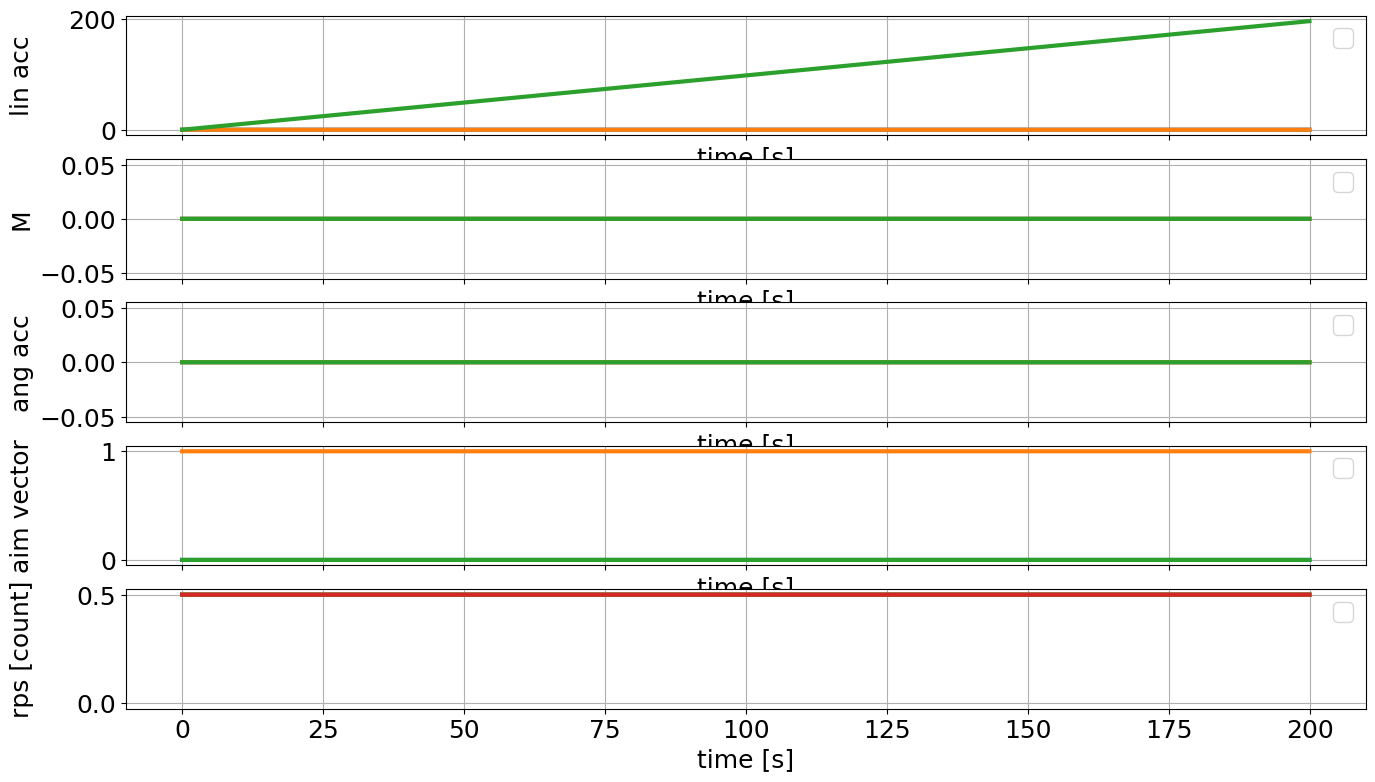

In [287]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
fig

In [288]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5215
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2117

Total number of variables............................:     1340
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1215
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1000004e+01 3.92e-05 1.48e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [289]:
sim_graphics.clear()

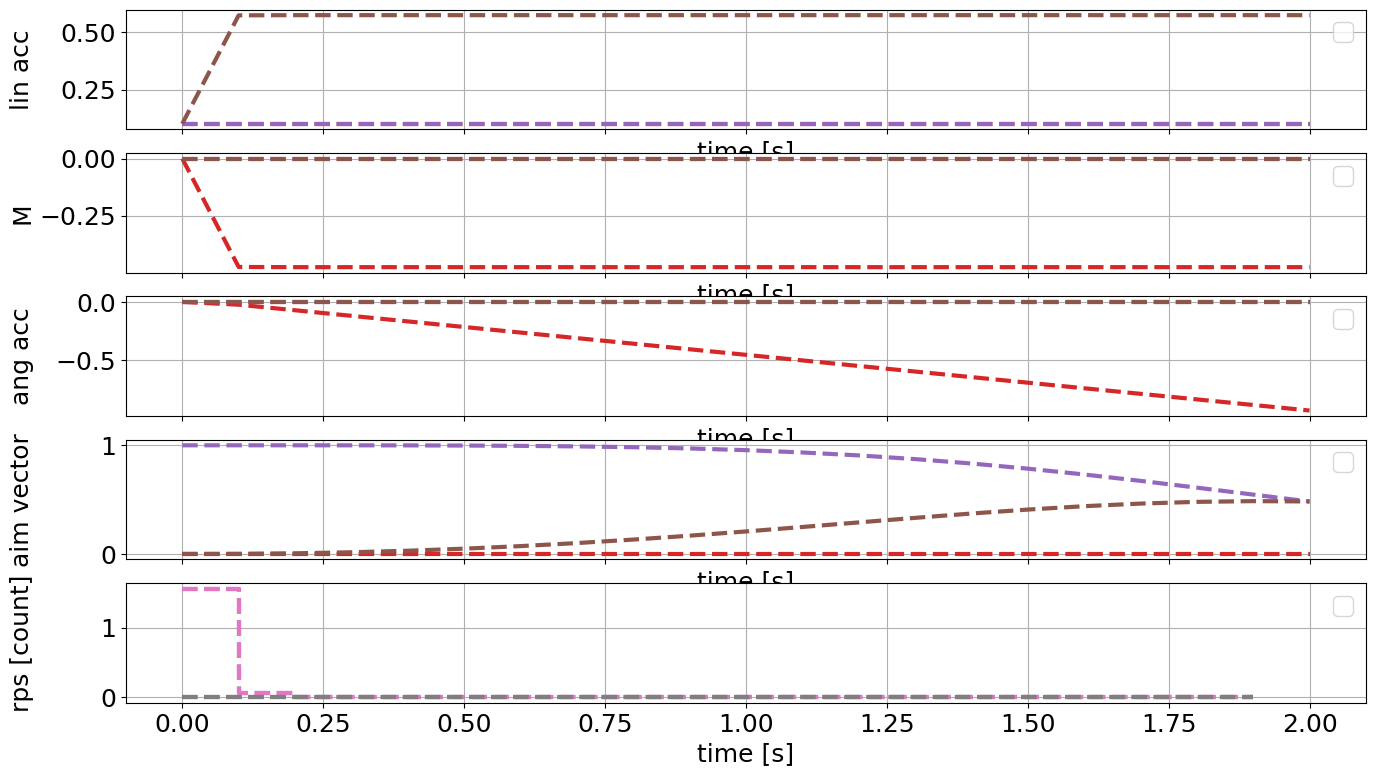

In [290]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [291]:
mpc_graphics.pred_lines

In [292]:
# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'lin']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'M']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'ang']: line_i.set_color('#2ca02c') # green
for line_i in mpc_graphics.pred_lines['_x', 'aim']: line_i.set_color('#2ca02c') # green
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'rps']: line_i.set_color('#1f77b4')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0)

In [293]:
# Get line objects (note sum of lists creates a concatenated list)
lines = sim_graphics.result_lines['_x', 'lin'] + sim_graphics.result_lines['_x', 'M'] + sim_graphics.result_lines['_x', 'ang'] + sim_graphics.result_lines['_x', 'aim']

ax[0].legend(lines,'xyz')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'rps']
ax[1].legend(lines,'1234')

In [297]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [298]:
%%capture
for i in range(1000):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

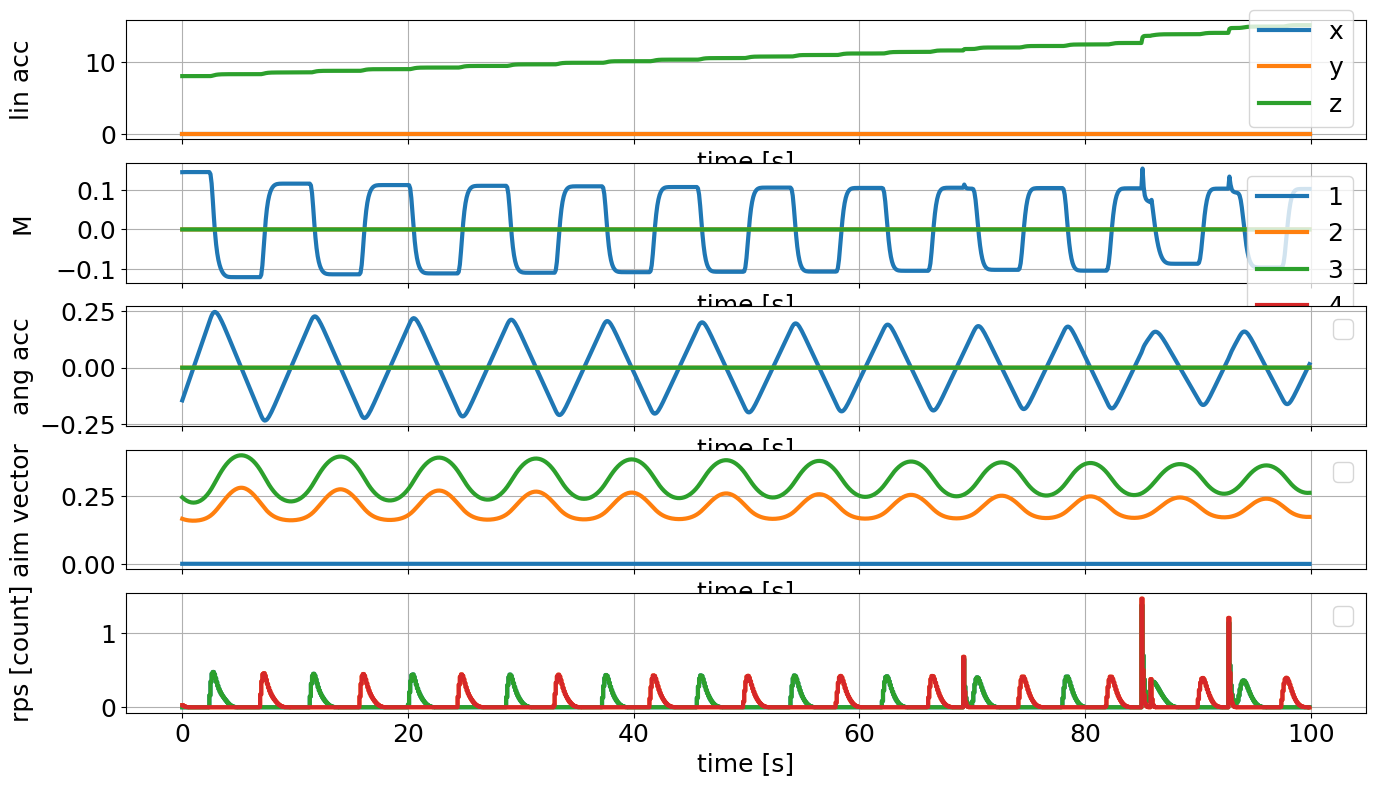

In [299]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig